In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

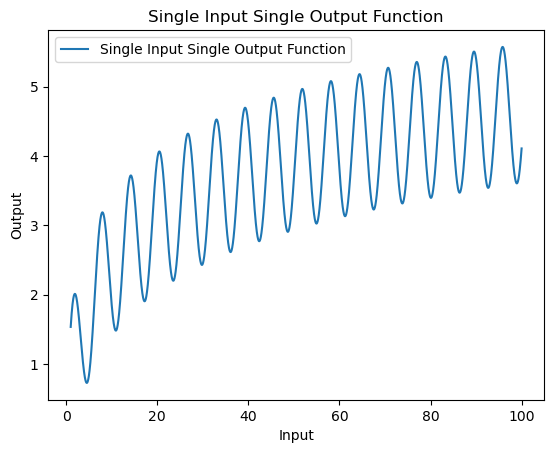

In [2]:
def target_function(x):
    return np.sin(x) + np.log(x + 1)

np.random.seed(0)
x_train = np.random.uniform(1, 100, 1000000).reshape(-1, 1)
y_train = target_function(x_train).reshape(-1, 1)

x_val = np.linspace(1, 100, 200000).reshape(-1, 1)
y_val = target_function(x_val).reshape(-1, 1)

# Plot the results
plt.plot(x_val, y_val, label='Single Input Single Output Function')
plt.title('Single Input Single Output Function')
plt.xlabel('Input')
plt.ylabel('Output')
plt.legend()
plt.show()

In [3]:
x_train = torch.from_numpy(x_train).float()
y_train = torch.from_numpy(y_train).float()
x_val = torch.from_numpy(x_val).float()
y_val = torch.from_numpy(y_val).float()

In [4]:
class DNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, no_of_layers):
        super(DNNModel, self).__init__()
        self.hidden_layers = nn.ModuleList([
            nn.Linear(input_size, hidden_size),
            nn.ReLU()
        ] + [nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU()
        ) for _ in range(no_of_layers)])
        self.output_layer = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        for layer in self.hidden_layers:
            x = layer(x)
        output = self.output_layer(x)
        return output

# Initialize models
model = DNNModel(1, 8, 1,7)  
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters())

print(sum(p.numel() for p in model.parameters()))

529


In [5]:
def train_model(model, optimizer, x_train, y_train, epochs=20000, tolerance=1e-5):
    model.train()
    losses = []
    grad_arr = []
    epoch_arr = []
    for epoch in range(epochs):
        epoch_arr.append(epoch)
        optimizer.zero_grad()
        outputs = model(x_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()
        
        losses.append(loss.item())
        
        grad_all = 0.0
        for p in model.parameters():
            grad = 0.0
            if p.grad is not None:
                grad = (p.grad.cpu().data.numpy()**2).sum()
            grad_all += grad
        grad_norm = grad_all ** 0.5
        
        grad_arr.append(grad_norm)
        
        if epoch % 100 == 0:
            print(f"Epoch {epoch}: Loss = {loss.item()}")

        # Check for convergence, assuming at least 2 epochs have been run
        if epoch > 5 and abs(losses[-2] - losses[-1]) < tolerance:
            print(f"Convergence reached at epoch {epoch}. Loss = {loss.item()}")
            break

    return losses, grad_arr, epoch_arr


losses, grad_arr, epoch_arr = train_model(model, optimizer, x_train, y_train)


Epoch 0: Loss = 14.390772819519043
Epoch 100: Loss = 1.8942220211029053
Epoch 200: Loss = 1.286916732788086
Epoch 300: Loss = 0.7597330212593079
Epoch 400: Loss = 0.5481820702552795
Convergence reached at epoch 490. Loss = 0.5038235783576965


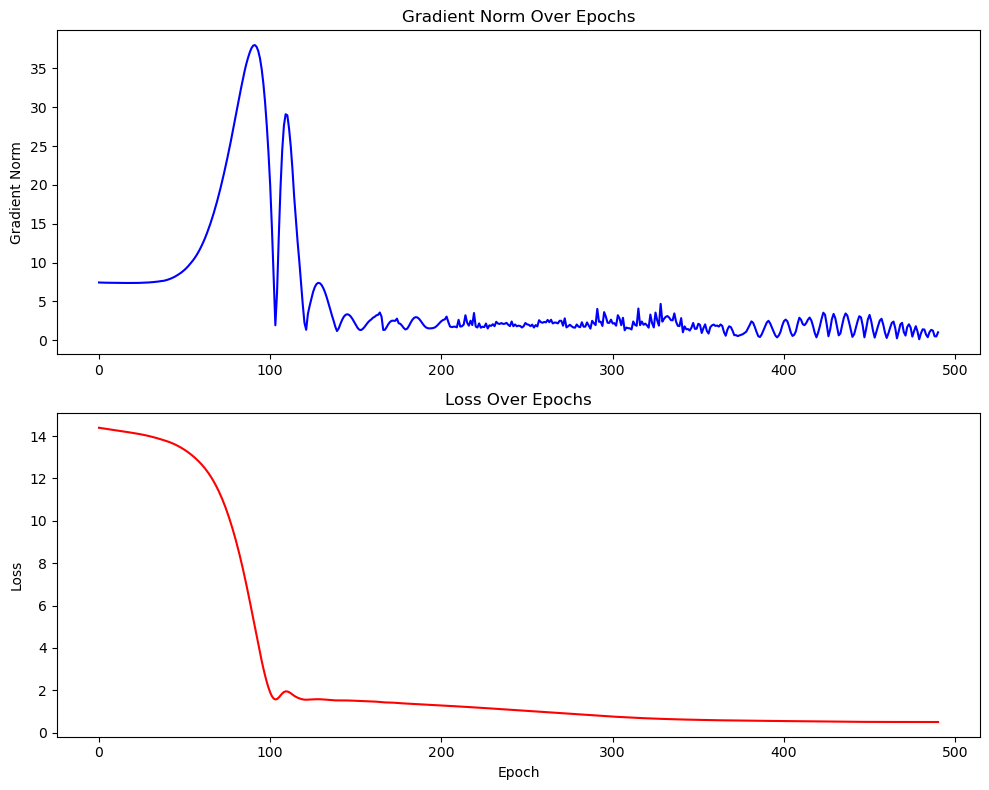

In [6]:
epochs = range(len(grad_arr))

fig, axs = plt.subplots(2, 1, figsize=(10, 8))

axs[0].plot(epochs, grad_arr, color='blue')
axs[0].set_title('Gradient Norm Over Epochs')
axs[0].set_ylabel('Gradient Norm')

axs[1].plot(epochs, losses, color='red')
axs[1].set_title('Loss Over Epochs')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')

plt.tight_layout()
plt.show()
